In [31]:
import matplotlib
print(matplotlib.matplotlib_fname())

C:\Users\johnn\Anaconda3\envs\pymc_env\lib\site-packages\matplotlib\mpl-data\matplotlibrc


In [33]:
import shutil
import matplotlib
shutil.rmtree(matplotlib.get_cachedir())

In [1]:
import matplotlib.font_manager
[f for f in matplotlib.font_manager.fontManager.ttflist if 'SimHei' in f.name]

[FontEntry(fname='C:\\Users\\johnn\\Anaconda3\\envs\\pymc_env\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\SimHei.ttf', name='SimHei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'),
 FontEntry(fname='C:\\Windows\\Fonts\\simhei.ttf', name='SimHei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'),
 FontEntry(fname='C:\\WINDOWS\\Fonts\\simhei.ttf', name='SimHei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')]

In [28]:
# import library
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime
import pytz
import os
import plotly.express as px
import geopandas as gpd
import folium
import branca
from tqdm.notebook import tqdm
from folium import Marker, FeatureGroup
from folium.plugins import MarkerCluster, FeatureGroupSubGroup, Search


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

#coding:utf-8
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['font.size'] = 20
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

sns.set(font_scale=1.5)
sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})

In [3]:
# get the current working directory
cwd = os.getcwd()

# print the current working directory
print(f"Current working directory: {cwd}")

path = '/Users/johnn/Documents/Research/codebook/covid/'
os.chdir(path)

# get the current working directory
cwd = os.getcwd()
# print the current working directory
print(f"Current working directory: {cwd}")


Current working directory: c:\Users\johnn\Documents\Research\codebook\covid
Current working directory: c:\Users\johnn\Documents\Research\codebook\covid


In [4]:
# define global parameters for web scrapping.
headers = {'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.84 Safari/537.36'}

In [5]:
def get_link(page):
    df_link = pd.DataFrame()
    link = []
    title = []
    url = 'https://ss.shanghai.gov.cn/service/wsjkw/search'
    key = '新增本土新冠肺炎'
    params = {"q": key, 'all':1, 'page': page, 'siteId':'wsjkw.sh.gov.cn', 'siteArea':'all'}
    results = requests.get(url, params=params, timeout=30, headers=headers)
    results.encoding = 'utf-8'
    soup = BeautifulSoup(results.text, 'lxml')
    for x in soup.find_all(class_ = 'result'):
        title.append(x.find('a').get('title'))
        link.append(x.find(class_='url').find('a').get('href'))

    df_link['link'] = link
    df_link['title'] = title

    return df_link

In [6]:
df_link = pd.DataFrame()
num_pages = 4
for page in tqdm(range(num_pages)):
    df_link = df_link.append(get_link(page+1), ignore_index=True)

# clean date
date = []
for idx, row in tqdm(df_link.iterrows(), total=df_link.shape[0]):
    date_ = re.findall('(?:\d+年)?(\d+月\d+日)', row['title'])    
    if date_:
        date.append('2022年' + date_[0])
    else:
        date.append('2022年3月28日')

df_link['date'] = pd.to_datetime(date, format='%Y年%m月%d日')
df_link.sort_values(by='date', inplace=True)
df_link.reset_index(inplace=True,drop=True)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

In [7]:
def parse_report(link):
    # define regex
    regex = '(?:病例|无症状感染者)(\d+)(?:\、|\—)?(?:病例|无症状感染者)?(\d*)' 
    
    r = requests.get(link, headers=headers)
    r.encoding = 'utf-8'
    soup = BeautifulSoup(r.text, 'lxml')
    # find article content
    article = soup.find(class_="Article_content")
    
    # create flags
    need_date_flag = True
    previous_context = ''

    # different case types
    case_types = ['风险人群筛查中', 
                  '本市闭环隔离管控人员', '密切接触者', '系外省返沪协查人员核酸筛查异常',
                  '此前报告的本土无症状感染者']
    # different positive case types
    positive_case_types = ['病例', '无症状感染者']
    # create empty df
    df = pd.DataFrame()
    for child in article.children:
        # find date
        if need_date_flag:
            capture_date = re.search('\d+年\d+月\d+日', child.text)
            if capture_date:
                date = pd.to_datetime(capture_date.group(0), format="%Y年%m月%d日")
                need_date_flag = False
                continue
        
        # find the content
        need_continue_flag = not bool(re.search("[\。\）]$", child.text))
        article_flag = '居住于' in child.text
        if article_flag & need_continue_flag:
            previous_context += child.text
            continue
        elif article_flag & ~need_continue_flag:
            context = previous_context + child.text
            district_ = re.findall('(?:居住于[\，|\"]?)?([\u4E00-\u9FA5]+区|来沪求职)(?:[\u4E00-\u9FA5\da-zA-Z]*)(?=\，|\s)', context)
            #district_ = re.findall("(?:居住于)(?:\，)?([\u4E00-\u9FA5]+)(?=\，)", context)
            cases_ = re.findall(regex, context)
            try:
                assert len(cases_) == len(district_)
            except:
                print("Different length of case number and districts")
                print(context)
                print('date: {}'.format(date.strftime(format='%Y-%m-%d')))
                print("The length of case: {}".format(len(cases_)))
                print("The length of district: {}".format((district_)))
            cases_number = [int(case[1]) - int(case[0]) + 1 if case[1] else 1 for case in cases_]
            
            # define the case type
            if case_types[0] in context:
                case_type_ = 'A'
            elif case_types[1] in context:
                case_type_ = 'B'
            elif case_types[2] in context:
                case_type_ = 'B'
            elif case_types[3] in context:
                case_type_ = 'B'
            elif case_types[4] in context:
                case_type_ = 'C'
            else:
                case_type_ = None
            
            # define the positive case type
            if positive_case_types[0] in context:
                positive_case_type_ = 'positive'
            elif positive_case_types[1] in context:
                positive_case_type_ = 'asym'
            else:
                positive_case_type_ = None 

            # reset previous context
            previous_context = ''

            df_ = pd.DataFrame({'cases':cases_, 
                                'district':district_, 
                                'cases_number': cases_number})
            df_['case_type'] = case_type_
            df_['positive_case_type'] = positive_case_type_
        else:
            continue 
        
        # append the dataframe
        df = df.append(df_, ignore_index=True)
        df['date'] = date
    
    return df

    

In [8]:
mask = df_link['date'] > pd.to_datetime('2022-03-13')
df_link_subset = df_link.loc[mask, :]
df = pd.DataFrame()
for idx, row in tqdm(df_link_subset.iterrows(), total=df_link_subset.shape[0]):
    df = df.append(parse_report(row['link']), ignore_index=True)

  0%|          | 0/44 [00:00<?, ?it/s]

In [9]:
df_copy = df.copy()
df_copy['district'] = df.district.str.rsplit('区', expand=True).loc[:, 0] + '区'

In [10]:
df_copy['district'].replace('闵行校区', '闵行区', inplace=True)
df_copy = df_copy[df_copy['district'] != '来沪求职区']

In [11]:
df_table = pd.pivot_table(data=df_copy, values='cases_number', 
                          index=['positive_case_type', 'date', 'district'], columns='case_type', 
                          fill_value=0, aggfunc='sum')

In [12]:
df_table_pct = df_table.div(df_table.sum(axis=1), axis=0)

<AxesSubplot:xlabel='date'>

findfont: Font family ['Arial Unicode MS'] not found. Falling back to DejaVu Sans.


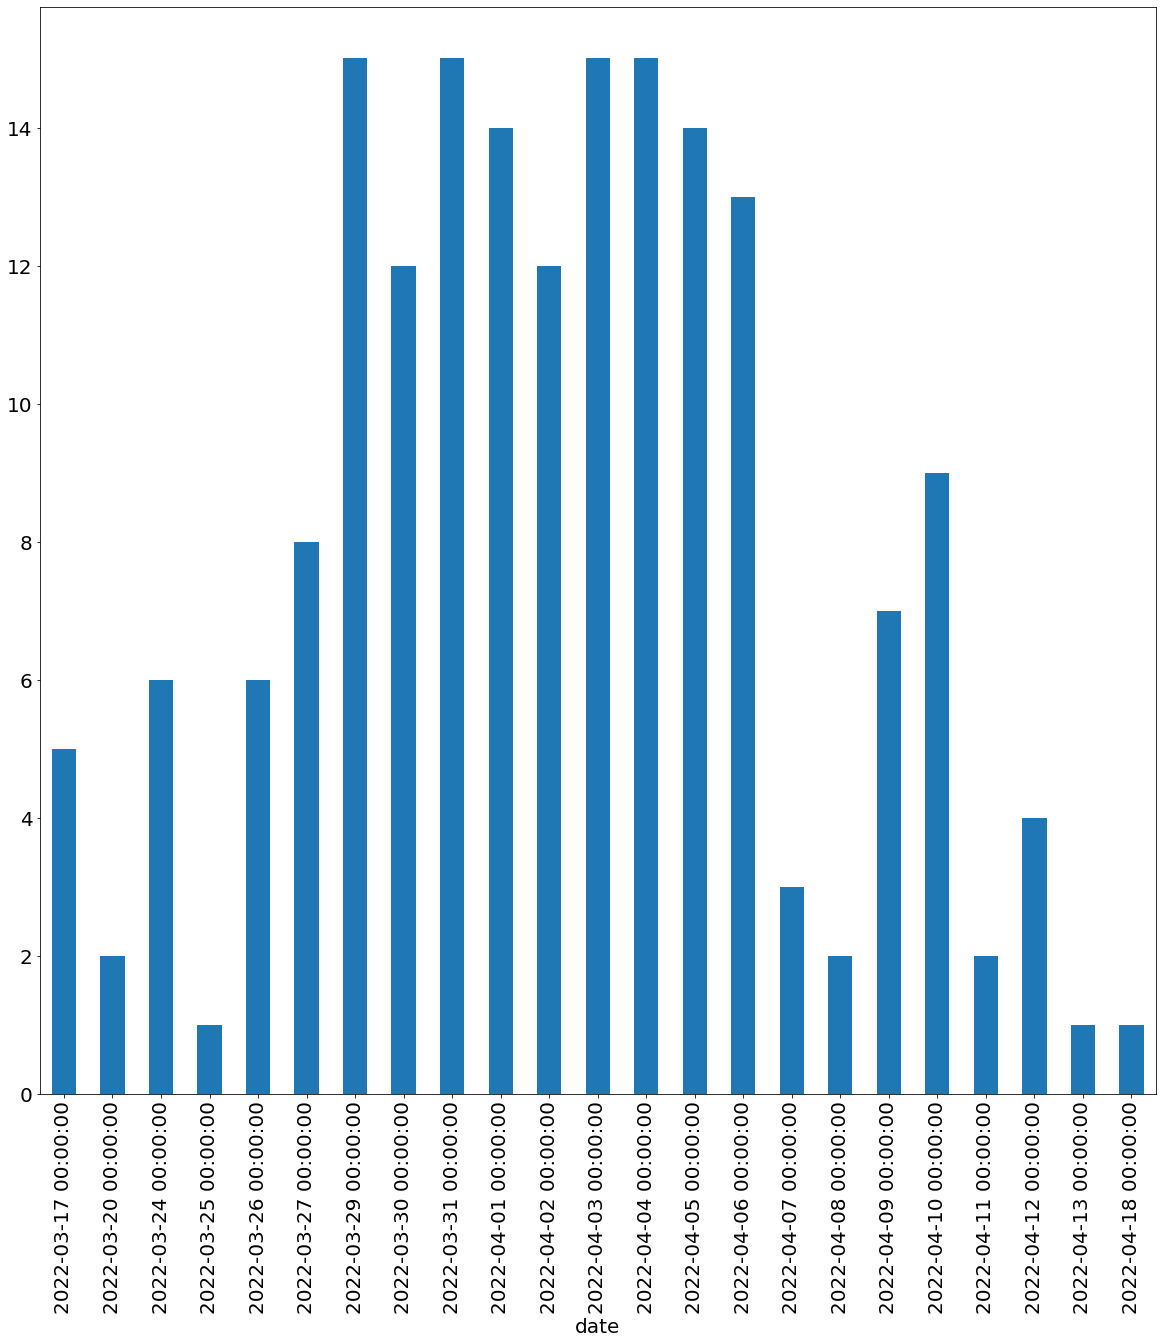

In [13]:
idx = pd.IndexSlice

df_table_pct.loc[df_table_pct['A'] > 0.5, 'A'].xs('positive', level=0, drop_level=True).groupby(level=[0]).size().plot(kind='bar', x='date')

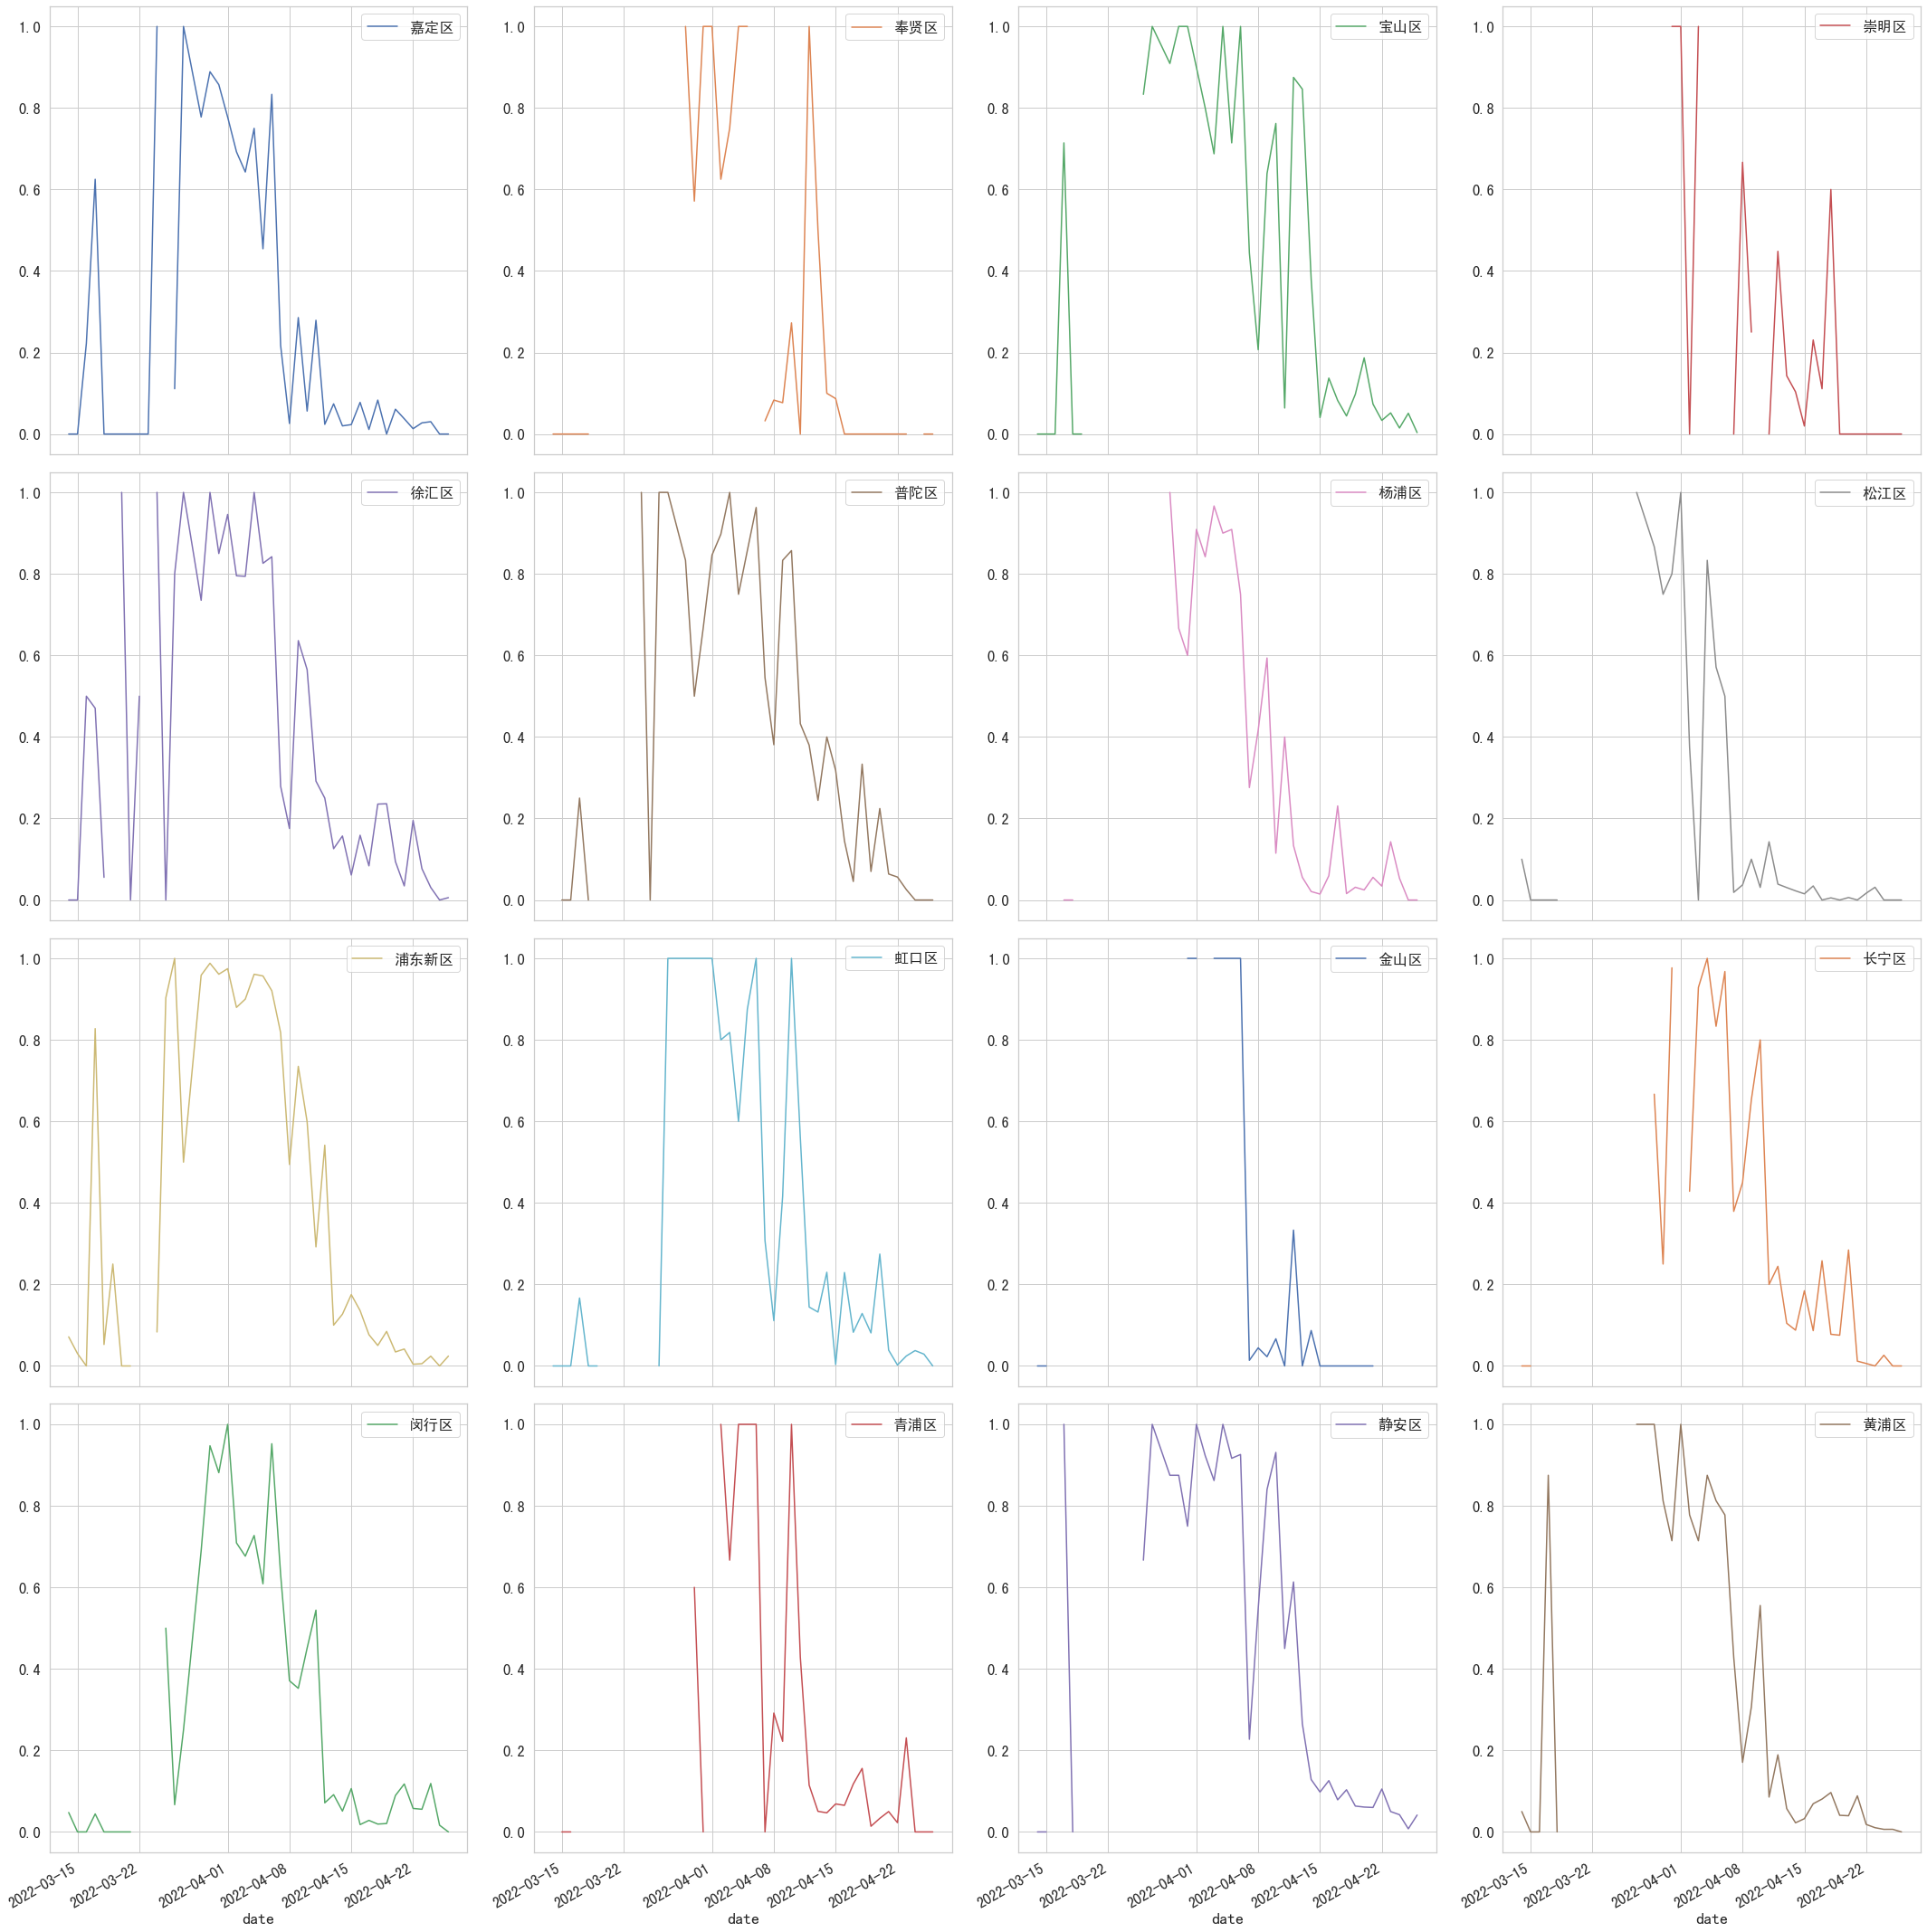

In [31]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})

ax = df_table_pct.loc[idx["positive", :, :], "A"].reset_index(level=0, drop=True).unstack(1).plot(kind='line', 
                            subplots=True, rot=0, figsize=(30, 30), layout=(4,4))
plt.gcf().autofmt_xdate()
plt.tight_layout()

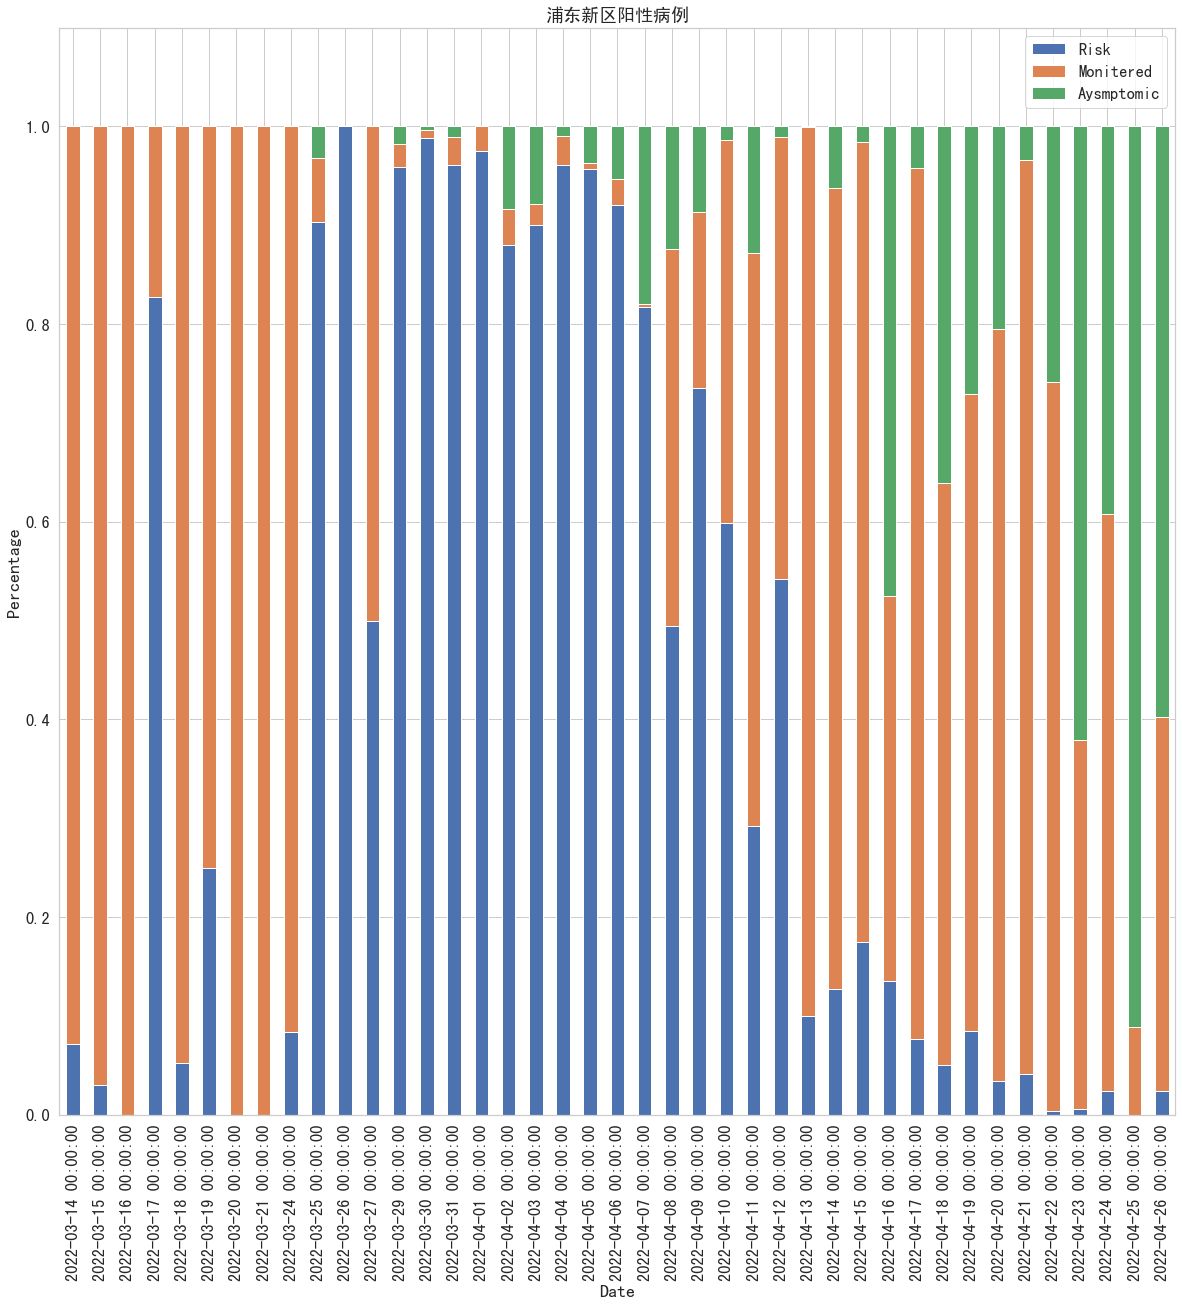

In [32]:
idx = pd.IndexSlice
positive_case_type = 'positive'
district_selected = '浦东新区'
district_selected_pinyin = 'Pudong'

ax = df_table_pct.loc[idx[positive_case_type, :, district_selected], :].reset_index(level=1).plot(kind='bar', x = 'date', stacked=True, 
                                                                title='浦东新区阳性病例',
                                                                mark_right=True,figsize=(20, 20), 
                                                                ylim=[0, 1.1])
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.legend(loc='best', labels=['Risk', 'Monitered', 'Aysmptomic'])

In [29]:
df_table_pct.reset_index(level=1)['date'].dtypes

dtype('<M8[ns]')

In [33]:
ax.get_xticks()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In [433]:
df_table_all = df_table.groupby(level=[0, 1]).sum()

In [434]:
df_table_all.index

MultiIndex([(    'asym', '2022-03-14'),
            (    'asym', '2022-03-15'),
            (    'asym', '2022-03-16'),
            (    'asym', '2022-03-17'),
            (    'asym', '2022-03-18'),
            (    'asym', '2022-03-19'),
            (    'asym', '2022-03-20'),
            (    'asym', '2022-03-21'),
            (    'asym', '2022-03-22'),
            (    'asym', '2022-03-23'),
            (    'asym', '2022-03-24'),
            (    'asym', '2022-03-25'),
            (    'asym', '2022-03-26'),
            (    'asym', '2022-03-27'),
            (    'asym', '2022-03-29'),
            (    'asym', '2022-03-30'),
            (    'asym', '2022-03-31'),
            (    'asym', '2022-04-01'),
            (    'asym', '2022-04-02'),
            (    'asym', '2022-04-03'),
            (    'asym', '2022-04-04'),
            (    'asym', '2022-04-05'),
            (    'asym', '2022-04-06'),
            (    'asym', '2022-04-07'),
            (    'asym', '2022-04-08'),


In [480]:
np.repeat(df_table_all.sum(axis=1).values, 3, axis=1).shape

AxisError: axis 1 is out of bounds for array of dimension 1

In [482]:
df_table_all.div(df_table_all.sum(axis=1), axis=0)

case_type                             A         B         C
positive_case_type date                                    
asym               2022-03-14  1.000000  0.000000  0.000000
                   2022-03-15  1.000000  0.000000  0.000000
                   2022-03-16  0.909091  0.090909  0.000000
                   2022-03-17  1.000000  0.000000  0.000000
                   2022-03-18  1.000000  0.000000  0.000000
...                                 ...       ...       ...
positive           2022-04-21  0.053340  0.872605  0.074055
                   2022-04-22  0.027047  0.563596  0.409357
                   2022-04-23  0.031406  0.582441  0.386153
                   2022-04-24  0.027913  0.629854  0.342233
                   2022-04-25  0.010837  0.406382  0.582781

[84 rows x 3 columns]

In [453]:
df_table_all_pct = df_table_all.div(df_table_all.sum(axis=1), axis=0)

In [458]:
df_table_all_pct[df_table_all_pct.sum(axis=1).values != 1.0]

,case_type,A,B,C
positive_case_type,date,,,
positive,2022-03-16,0.071429,0.914286,0.014286


C:\Users\johnn\Anaconda3\envs\pymc_env\lib\site-packages\matplotlib\mpl-data\matplotlibrc
